# Fully connected TensorFlow model - Learning curve 

## Aims

* Ascertain the relationship between training set size and model accuracy

## Basic methodology

* Models are fitted to a single fold of previously split k-fold training and test data sets. 

* MinMax scaling is used (all features are scaled 0-1 based on the fature min/max).

* Model has two hidden layers, each with the number of neurones being 2x the number of features. Prior studies show performance of the network is similar across all models with this complexity or more. A dropout value of 0.5 is used based on previous exploration.

* A batch size of 32 is used ("Friends don't let friends use minibatches larger than 32". Yan LeCun on paper: arxiv.org/abs/1804.07612)

* 30 Training epochs are used as previously established.

* Adjust size of training set

Model structure:

* Input layer
* Dense layer (# neurones = 2x features, ReLu activation)
* Batch normalisation 
* Dropout layer
* Dense layer (# neurones = 2x features, ReLu activation)
* Batch normalisation 
* Dropout layer
* Output layer (single sigmoid activation)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Function to scale data (minmax scaling)

In [2]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc  

## Define neural net

In [3]:
def make_net(number_features, expansion=2, learning_rate=0.003, dropout=0.5):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Input layer
    inputs = layers.Input(shape=number_features)
    
    # Dense layer 1
    dense_1 = layers.Dense(
        number_features * expansion, activation='relu')(inputs)
    norm_1 = layers.BatchNormalization()(dense_1)
    dropout_1 = layers.Dropout(dropout)(norm_1)
    
    # Dense layer 2
    dense_2 = layers.Dense(
        number_features * expansion, activation='relu')(dropout_1)
    norm_2 = layers.BatchNormalization()(dense_2)
    dropout_2 = layers.Dropout(dropout)(norm_2)    
 
    # Outpout (single sigmoid)
    outputs = layers.Dense(1, activation='sigmoid')(dropout_2)
    
    # Build net
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

## Run k-fold validation with varying training set sizes

In [4]:
# Set up list to collect results
results_training_size = []
results_accuracy = []
results_all_accuracy = []

# Get maximum training size (number of training records)
train_data = pd.read_csv(f'../data/kfold_5fold/train_0.csv')
max_training_size = train_data.shape[0]

# Construct training sizes (values closer at lower end)
train_sizes = [50, 100, 250, 500, 1000, 2500]
for i in range (5000, max_training_size, 5000):
    train_sizes.append(i)
    
# Loop through training sizes
for train_size in train_sizes:
    
    # Record accuracy across k-fold replicates
    replicate_accuracy = []

    for k in range(5):
        
        # Load data
        train = pd.read_csv(f'../data/kfold_5fold/train_{k}.csv')
        test = pd.read_csv(f'../data/kfold_5fold/test_{k}.csv')
        
        # OneHot encode stroke team
        coded = pd.get_dummies(train['StrokeTeam'])
        train = pd.concat([train, coded], axis=1)
        train.drop('StrokeTeam', inplace=True, axis=1)
        coded = pd.get_dummies(test['StrokeTeam'])
        test = pd.concat([test, coded], axis=1)
        test.drop('StrokeTeam', inplace=True, axis=1)
        
        # Sample from training data
        train = train.sample(n=train_size)

        # Split into X, y
        X_train_df = train.drop('S2Thrombolysis',axis=1) 
        y_train_df = train['S2Thrombolysis']
        X_test_df = test.drop('S2Thrombolysis',axis=1) 
        y_test_df = test['S2Thrombolysis'] 

        # Convert to NumPy
        X_train = X_train_df.values
        X_test = X_test_df.values
        y_train = y_train_df.values
        y_test = y_test_df.values
        
        # Scale data
        X_train_sc, X_test_sc = scale_data(X_train, X_test)

        # Define network
        number_features = X_train_sc.shape[1]
        model = make_net(number_features)
       
        # Train model (including class weights)
        history = model.fit(X_train_sc,
                            y_train,
                            epochs=30,
                            batch_size=32,
                            validation_data=(X_test_sc, y_test),
                            verbose=0)

        # Predict test set
        probability = model.predict(X_test_sc)
        y_pred_test = probability >= 0.5
        y_pred_test = y_pred_test.flatten()
        accuracy_test = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy_test)
        results_all_accuracy.append(accuracy_test)
    
    # Store mean accuracy across the k-fold splits
    mean_accuracy = np.mean(accuracy_test)
    results_accuracy.append(mean_accuracy)
    results_training_size.append(train_size)
    
    # Print output
    print (f'Training set size {train_size}, accuracy: {mean_accuracy:0.3f}')

k_fold_accuracy = np.array(results_all_accuracy).reshape(len(train_sizes), 5)    

Training set size 50, accuracy: 0.669
Training set size 100, accuracy: 0.713
Training set size 250, accuracy: 0.761
Training set size 500, accuracy: 0.759
Training set size 1000, accuracy: 0.765
Training set size 2500, accuracy: 0.794
Training set size 5000, accuracy: 0.808
Training set size 10000, accuracy: 0.823
Training set size 15000, accuracy: 0.828
Training set size 20000, accuracy: 0.834
Training set size 25000, accuracy: 0.837
Training set size 30000, accuracy: 0.837
Training set size 35000, accuracy: 0.840
Training set size 40000, accuracy: 0.834
Training set size 45000, accuracy: 0.839
Training set size 50000, accuracy: 0.839
Training set size 55000, accuracy: 0.840
Training set size 60000, accuracy: 0.839
Training set size 65000, accuracy: 0.843
Training set size 70000, accuracy: 0.844


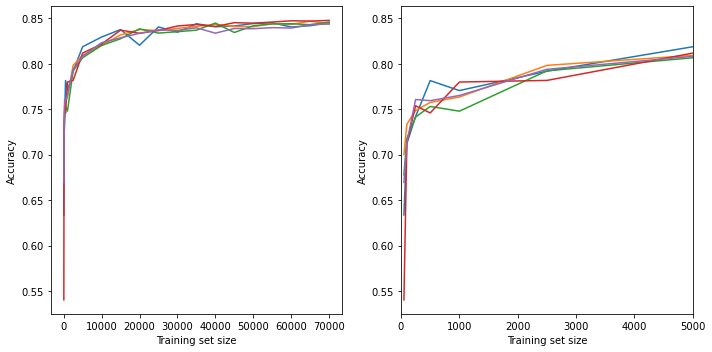

In [5]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for i in range(5):
    ax1.plot(results_training_size, k_fold_accuracy[:, i])

ax1.set_xlabel('Training set size')
ax1.set_ylabel('Accuracy')

# Focus on first 5000
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(results_training_size, k_fold_accuracy[:, i])

ax2.set_xlabel('Training set size')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, 5000)

plt.tight_layout()
plt.savefig('./output/nn_fc_learning_curve.jpg', dpi=300)
plt.show()

## Observations

* Training accuracy rises, and then increases only slightly over 25,000 training samples.